In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import xgboost as xgb
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
train= pd.read_csv("data/train/train.csv")
test= pd.read_csv("data/test/13.csv")
sub= pd.read_csv("data/sample_submission.csv")

In [30]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('data/test/%d.csv')"%(i,i)
    exec(s1)

In [31]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [32]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
91,1,21,30,0,0,2.2,74.50,-8,0.0,0.0
92,1,22,0,0,0,2.2,72.83,-8,0.0,0.0
93,1,22,30,0,0,2.2,72.82,-8,0.0,0.0
94,1,23,0,0,0,2.2,72.51,-8,0.0,0.0


In [33]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

각 시간대의 target 평균값을 'Hour_mean'에 대입
각 분대의 target평균값을 'Minute'에 대입 => 이부분은 문제있음 :: 모든시간대의 Minute값을 하나로 평균내버림

In [34]:
#변수생성
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

D일H시M분의 2일 후 데이터 밑 그 시간대의 target평균

In [35]:
train_x['Minute_mean']

0        17.810955
1        17.799137
2        17.810955
3        17.799137
4        17.810955
           ...    
52459    17.799137
52460    17.810955
52461    17.799137
52462    17.810955
52463    17.799137
Name: Minute_mean, Length: 52464, dtype: float64

In [36]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x

,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
0,0,0,1.5,69.08,-12,0.0,0.0,0.0,17.810955
1,0,0,1.5,69.06,-12,0.0,0.0,0.0,17.799137
2,0,0,1.6,71.78,-12,0.0,0.0,0.0,17.810955
3,0,0,1.6,71.75,-12,0.0,0.0,0.0,17.799137
4,0,0,1.6,75.20,-12,0.0,0.0,0.0,17.810955
...,...,...,...,...,...,...,...,...,...
52459,0,0,3.5,55.97,-1,0.0,0.0,0.0,17.799137
52460,0,0,3.9,54.23,-2,0.0,0.0,0.0,17.810955
52461,0,0,4.1,54.21,-2,0.0,0.0,0.0,17.799137
52462,0,0,4.3,56.46,-2,0.0,0.0,0.0,17.810955


In [37]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [38]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)#이부분 수정 필요
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [39]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,0,0,2.1,52.83,-4.4,0.0,0.0,6.061008
1,0,0,2.0,54.44,-4.8,0.0,0.0,5.926100
2,0,0,1.9,52.78,-5.1,0.0,0.0,6.061008
3,0,0,1.8,53.59,-5.3,0.0,0.0,5.926100
4,0,0,1.7,52.63,-5.5,0.0,0.0,6.061008
...,...,...,...,...,...,...,...,...
187,0,0,1.7,43.65,-5.2,0.0,0.0,11.308777
188,0,0,1.5,40.62,-4.9,0.0,0.0,11.297040
189,0,0,1.5,40.62,-4.9,0.0,0.0,11.308777
190,0,0,1.5,39.21,-4.9,0.0,0.0,11.297040


In [40]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [46]:
x_test = test_x.copy()

각 변수 간의 모든 조합(ex: (Hour_mean,)     or (TARGET, Hour_mean)    등)간의 RSS값 연구
,단 조합은 Hour_mean부터 순서대로 column의 왼쪽으로 추가되고 마지막에 Minute_mean이 추가됨 

In [54]:
def xgb(X,y):
    model = xgb.XGBClassifier(fit_intercept = True,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

#X변수 개수
m = len(y_train)
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 8까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = xgb(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

C:\Users\user\anaconda3\envs\open source sw class\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


AttributeError: 'function' object has no attribute 'XGBClassifier'

In [48]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,1.762009e+07,0.494386,"(DHI,)",1.058685e+07,0.696207
1,1,2.235501e+07,0.358516,"(DNI,)",1.058685e+07,0.696207
2,1,3.281036e+07,0.058496,"(WS,)",1.058685e+07,0.696207
3,1,2.265496e+07,0.349909,"(RH,)",1.058685e+07,0.696207
4,1,2.578791e+07,0.260008,"(T,)",1.058685e+07,0.696207


In [49]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min.head(8))

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
6,1,1.058685e+07,0.696207,"(Hour_mean,)",1.058685e+07,0.696207
33,2,8.892195e+06,0.744836,"(TARGET, Hour_mean)",8.892195e+06,0.744836
69,3,8.319371e+06,0.761273,"(DNI, TARGET, Hour_mean)",8.319371e+06,0.761273
143,4,8.105550e+06,0.767409,"(DNI, T, TARGET, Hour_mean)",8.105550e+06,0.767409
178,5,8.092551e+06,0.767782,"(DHI, DNI, T, TARGET, Hour_mean)",8.092551e+06,0.767782
224,6,8.090475e+06,0.767841,"(DHI, DNI, WS, T, TARGET, Hour_mean)",8.090475e+06,0.767841
246,7,8.089535e+06,0.767868,"(DHI, DNI, WS, RH, T, TARGET, Hour_mean)",8.089535e+06,0.767868
254,8,8.089526e+06,0.767868,"(DHI, DNI, WS, RH, T, TARGET, Hour_mean, Minut...",8.089526e+06,0.767868


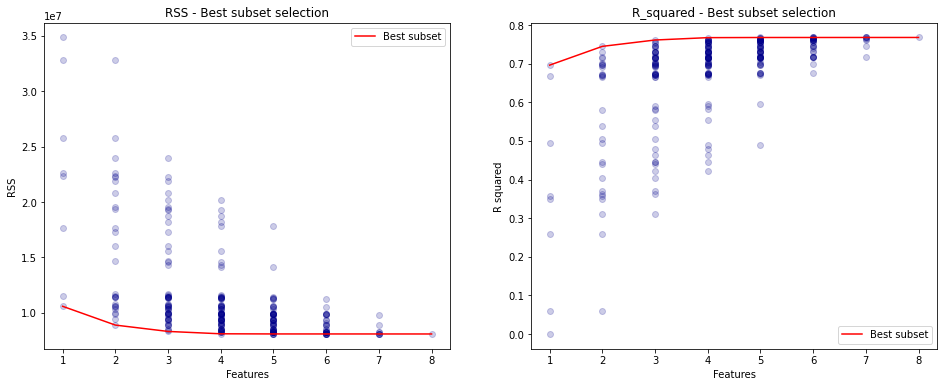

In [50]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

['Hour_mean']값은 quantileregression에 대입함

In [51]:
sub['q_0.1'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.1).predict(x_test['Hour_mean'])
sub['q_0.2'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.2).predict(x_test['Hour_mean'])
sub['q_0.3'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.3).predict(x_test['Hour_mean'])
sub['q_0.4'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.4).predict(x_test['Hour_mean'])
sub['q_0.5'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.5).predict(x_test['Hour_mean'])
sub['q_0.6'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.6).predict(x_test['Hour_mean'])
sub['q_0.7'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.7).predict(x_test['Hour_mean'])
sub['q_0.8'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.8).predict(x_test['Hour_mean'])
sub['q_0.9'] = QuantReg(y_train, x_train['Hour_mean']).fit(q=0.9).predict(x_test['Hour_mean'])

In [ ]:
display(sub[:80])